# Stcu  Polarization Rendering

This notebook demonstrates polarization rendering of a pure stratocumulus cloud field within a rayeliegh scattering atmosphere. 

---

Related tutorials: 
 - Make Mie Table Polarized.ipynb - create mie tables.
 - Rayleigh Polarization Rendering.ipynb - rendering of a pure Rayleigh scattering atmosphere.
 - Mie Polarization Rendering.ipynb - rendering of a pure Mie scattering atmosphere.

---

The source Fortran code was created by Frank Evans and it is part of the SHDOM package: http://nit.colorado.edu/shdom.html

The python wrapper was created by Aviad Levis, Technion Inst. of Technology 2019: https://github.com/aviadlevis/pyshdom

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
"""
Load a Stratocumulus cloud field from SHDOM original distribution.
The atmosphere contains both Rayleigh and Mie scattering.
"""
wavelength = 0.8

# Mie scattering for water droplets
mie = shdom.MiePolydisperse()
mie.read_table(file_path='../mie_tables/polydisperse/Water_{}nm.scatpol'.format(shdom.int_round(wavelength)))

# Generate a Microphysical medium
droplets = shdom.MicrophysicalScatterer()
droplets.load_from_csv('../synthetic_cloud_fields/shdom/les_stcu.txt', veff=0.1)
droplets.add_mie(mie)

# Rayleigh scattering for air molecules
temperatures = np.array([283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11, 
                         281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
temperature_profile = shdom.GridData(shdom.Grid(z=droplets.grid.z), temperatures)
rayleigh = shdom.Rayleigh(wavelength)
rayleigh.set_profile(temperature_profile)

atmosphere = shdom.Medium(droplets.grid + rayleigh.grid)
atmosphere.add_scatterer(droplets, name='droplets')
atmosphere.add_scatterer(rayleigh.get_scatterer(), name='air')

numerical_params = shdom.NumericalParameters()
scene_params = shdom.SceneParameters(
    wavelength=wavelength,
    source=shdom.SolarSource(azimuth=0, zenith=180),
    boundary_conditions={'x': shdom.BC.periodic, 'y': shdom.BC.periodic},
)

rte_solver = shdom.RteSolver(scene_params, numerical_params, num_stokes=3)
rte_solver.set_medium(atmosphere)

Reading mie table from file: ../mie_tables/polydisperse/Water_800nm.scatpol


In [3]:
"""
Define the numerical and scene parameter and Solve the 
Polarized Radiative Transfer for the domain using SHDOM: 
SOLVE_RTE procedure (src/polarized/shdomsub1.f).
"""
rte_solver.solve(maxiter=100)

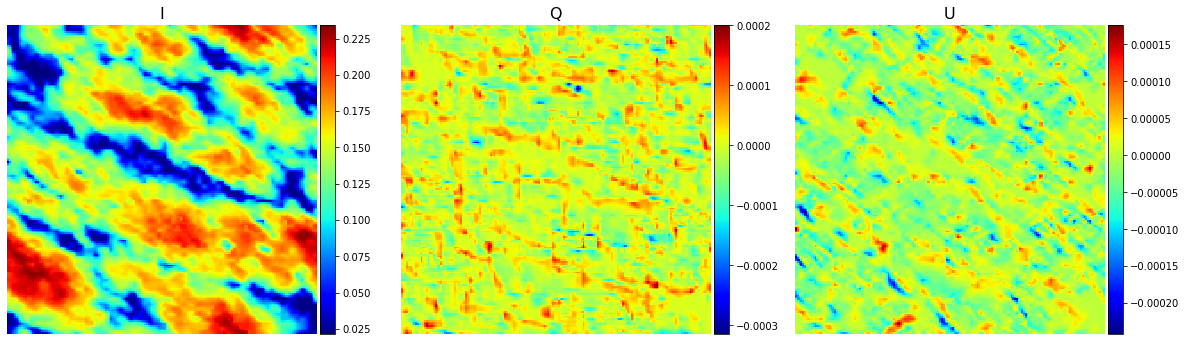

In [4]:
"""
Define a camera projection model and render the [I, Q, U] Stokes components.
"""
projection = shdom.OrthographicProjection(
    bounding_box=droplets.grid.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)
camera = shdom.Camera(shdom.StokesSensor(), projection)
stokes = camera.render(rte_solver, n_jobs=40)

%matplotlib inline
imgs = []
fig, axes = plt.subplots(1, 3, figsize=(20, 8));
imgs.append(axes[0].imshow(stokes[0,:]));
axes[0].set_title('I', fontsize=16);
imgs.append(axes[1].imshow(stokes[1,:]));
axes[1].set_title('Q', fontsize=16);
imgs.append(axes[2].imshow(stokes[2,:]));
axes[2].set_title('U', fontsize=16);

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax);
    cax = divider.append_axes("right", size="5%", pad=0.05);
    img.set_cmap('jet');
    plt.colorbar(img, cax=cax);
    ax.set_axis_off();

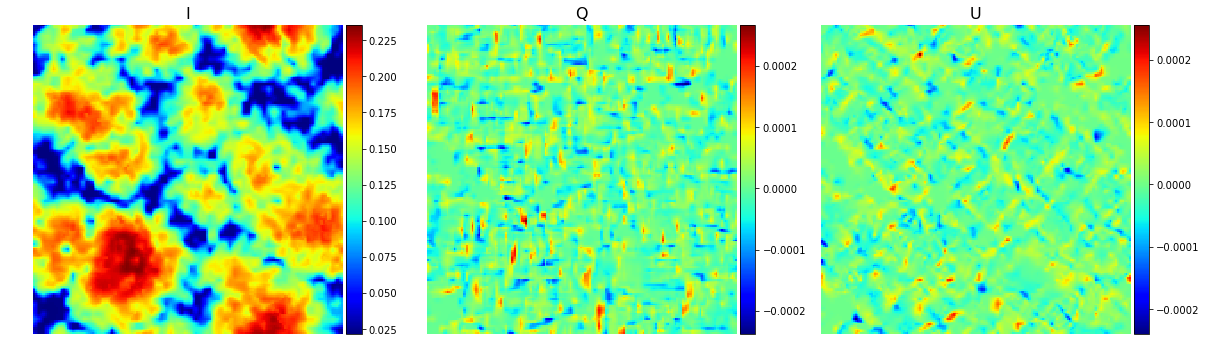

In [7]:
"""
Define a camera projection model and render the [I, Q, U] Stokes components.
"""
projection = shdom.OrthographicProjection(
    bounding_box=cloud.bounding_box, 
    x_resolution=0.02, 
    y_resolution=0.02, 
    azimuth=0.0, 
    zenith=0.0,
    altitude='TOA'
)

camera = shdom.Camera(shdom.StokesSensor(), projection)
stokes = camera.render(rte_solver, n_jobs=40)

%matplotlib inline

imgs = []
fig, axes = plt.subplots(1, 3, figsize=(20, 8));
imgs.append(axes[0].imshow(stokes[0,:]));
axes[0].set_title('I', fontsize=16);
imgs.append(axes[1].imshow(stokes[1,:]));
axes[1].set_title('Q', fontsize=16);
imgs.append(axes[2].imshow(stokes[2,:]));
axes[2].set_title('U', fontsize=16);

for img, ax in zip(imgs, axes):
    divider = make_axes_locatable(ax);
    cax = divider.append_axes("right", size="5%", pad=0.05);
    img.set_cmap('jet');
    plt.colorbar(img, cax=cax);
    ax.set_axis_off();